In [32]:
import os 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import randrange
import datetime
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from itertools import product

In [33]:
import textwrap

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
from llf_core import overwrite_tree_response, predict_single_sample, \
build_regression_tree,uniqueness_not_ok,find_best_split,mean_loss,solve_llf_at_x0,weighted_ridge_regression

In [36]:
from llf_testing import generate_random_table,paper_data,generate_random_lin_table,\
paper_data2,paper_data2_gamma,paper_data2_poisson

In [37]:
from llf_testing import make_llf_model,batch_solve_llf,compare_models

In [38]:
from llf_testing import LLTree,LLForest

In [39]:
def merge_dicts(d1, d2):
    """
    Return a new dict that is the deep merge of d1 and d2.
    - If a key exists in only one dict, its value is copied.
    - If a key exists in both and both values are dicts, merge them recursively.
    - Otherwise, the value from d2 overwrites.
    """
    result = d1.copy()
    for key, val in d2.items():
        if (
            key in result 
            and isinstance(result[key], dict) 
            and isinstance(val, dict)
        ):
            # both are dicts: merge recursively
            result[key] = merge_dicts(result[key], val)
        else:
            # otherwise, overwrite/add from d2
            result[key] = val
    return result

In [40]:
def get_metadata(run_signature):
    directory = os.getcwd()
    if directory != '/Users/skrs/Documents/uni/maģistrs/results':
        raise Exception('wrong directory')
    path = directory + '/metadata/'+ run_signature + '.json'
    with open(path,'r') as rf:
        metadata = json.load(rf)
    return metadata

In [41]:
with open('best_params.json') as rf:
    bp = json.load(rf)

FileNotFoundError: [Errno 2] No such file or directory: 'best_params.json'

In [42]:
os.getcwd()

'/Users/skrs/Documents/uni/maģistrs/results'

In [14]:
hyperparam_names = ["forest_lambda","n_estimators","ridge_lambda","max_depth","min_leaf_size","omega"]
files = []
for fname in os.listdir():
    if 'experiments.json' not in fname:
        continue
    print(fname)
    with open(fname) as rf:
        files.append(json.load(rf))


d1 = files[0]
d2 = files[1]
merged = merge_dicts(d1, d2)

try:
    del merged['ayy']
except:
    pass

best_params = {}
for datasetname in merged.keys():
    best_param_combo = None
    best_avg = np.inf
    for param_combo_str in merged[datasetname].keys():
        param_combo_error = merged[datasetname][param_combo_str]['avg_score']
        if param_combo_error < best_avg:
            best_param_combo = param_combo_str
            best_avg = param_combo_error
    best_params[datasetname] = {'best_param_combo':best_param_combo,'best_avg':best_avg}

with open('best_params.json','w') as wf:
    json.dump(best_params,wf,indent=2)

pc_run_experiments.json
run_experiments.json


In [19]:
pd.DataFrame(bp).T

,best_param_combo,best_avg
pub1 low var,"(0.5, 10, 0.1, 5, 25, 0.2)",4.96368
pub1 high var,"(0.5, 50, 0.1, 4, 20, 0.1)",20.182583
"gamma pub2, regular splits","(0.1, 10, 1, 4, 20, 0.2)",4.612966
"gamma pub2, gamma splits","(0.1, 20, 5, 4, 20, 0.2)",4.703171
pub2 low var,"(0.1, 20, 1, 4, 20, 0.2)",6.951666
pub2 high var,"(0.1, 10, 0.1, 4, 10, 0.05)",20.385098
lin,"(0.1, 20, 0.1, 4, 20, 0.2)",8.038021
"old hvar gamma pub2, gamma splits","(0.1, 20, 1, 4, 10, 0.2)",7.28978
"hvar gamma pub2, regular splits","(0.1, 20, 1, 4, 10, 0.2)",7.299392
"old pois pub2, pois splits","(0.1, 20, 0.1, 4, 20, 0.2)",4.889988


In [18]:
pd.DataFrame(bp)[['hvar pub2, lin splits','pub2 high var']].T.drop(columns=['best_param_combo'])

,best_avg
"hvar pub2, lin splits",20.378495
pub2 high var,20.385098


In [156]:
max_depth_grid = [4]
forest_lambda_grid = [0.1, 0.5,2,4]
ridge_lambda_grid = [0.1, 1, 5]
min_leaf_size_grid = [10, 20]
omega_grid = [0.05, 0.2]
n_estimators_grid = [10,20]

In [192]:
pd.DataFrame(bp)[['hvar pub2, lin splits','pub2 high var']].T.drop(columns=['best_param_combo'])

,best_avg
"hvar pub2, lin splits",20.378495
pub2 high var,20.385098


In [158]:
hyperparam_names = ["forest_lambda","n_estimators","ridge_lambda","max_depth","min_leaf_size","omega"]
files = []
for fname in os.listdir():
    if 'experiments.json' not in fname:
        continue
    print(fname)
    with open(fname) as rf:
        files.append(json.load(rf))


d1 = files[0]
d2 = files[1]
merged = merge_dicts(d1, d2)

try:
    del merged['ayy']
except:
    pass

best_params = {}
for datasetname in merged.keys():
    best_param_combo = None
    best_avg = np.inf
    for param_combo_str in merged[datasetname].keys():
        param_combo_error = merged[datasetname][param_combo_str]['avg_score']
        if param_combo_error < best_avg:
            best_param_combo = param_combo_str
            best_avg = param_combo_error
    best_params[datasetname] = {'best_param_combo':best_param_combo,'best_avg':best_avg}

with open('best_params.json','w') as wf:
    json.dump(best_params,wf,indent=2)

pc_run_experiments.json
run_experiments.json


In [160]:
for key in merged.keys():
    print(key," ",len(merged[key].keys()))

pub1 low var   95
pub1 high var   30
gamma pub2, regular splits   20
gamma pub2, gamma splits   31
pub2 low var   77
pub2 high var   107
lin   45
old hvar gamma pub2, gamma splits   31
hvar gamma pub2, regular splits   19
old pois pub2, pois splits   33
pois pub2, regular splits   45
pois pub2, pois splits   47
hvar gamma pub2, gamma splits   27
pub2, pois splits   34
pub2, gamma splits   24
pub1, pois splits   68
pub1, gamma splits   15
hvar pub2, pois splits   24
pub2, lin splits   96
pub2 high var 2k lines   4
hvar pub2, lin splits   61
pois pub2, lin splits   38


In [162]:
def get_best_hyperparams(key,best_params=best_params):
    combo = eval(best_params[key]['best_param_combo'])
    return dict(zip(hyperparam_names, combo))

In [163]:
def get_metadata(run_signature):
    directory = os.getcwd()
    if directory != '/Users/skrs/Documents/uni/maģistrs/results':
        raise Exception('wrong directory')
    path = directory + '/metadata/'+ run_signature + '.json'
#     print(path)
    with open(path,'r') as rf:
        metadata = json.load(rf)
        
    return metadata

In [20]:
allfiles = os.listdir()
csvs = []

entries = []
# 2025-05-06 17:27:54_with_12_cols_1000_rows__eq. 7 in llf publication with high variance__.csv
for elem in allfiles:
    if '.csv' not in elem:
        continue
        
    entry = {}
    split = elem.split('__')
    run_signature = split[0]
    timestamp = run_signature.split('with')[0].split("_")[0]
    title = split[1]
    split_type = title.split(' w ')[1]
    if title.split(' w ')[0].split('eq. 7 in llf publication')[1] != '':
        var_kind = 'high var'
    else:
        var_kind = 'low var'

    if title.split(' w ')[0].split('eq.')[0] == '':
        data_kind = 'regular'
    else:
        data_kind = 'pois'
    
    
    
    nr_rows = split[0].split("_")[4]
    nr_cols = split[0].split("_")[2]
    
    data = pd.read_csv(elem)
    data = data.rename({'Unnamed: 0':'model and metric'},axis=1)
    data = data.set_index('model and metric')
    
    df_rmse_dct = data.iloc[:3].T.to_dict()
    flattened = {f"{model} {split}": value for model, scores in df_rmse_dct.items() for split, value in scores.items()}
    
    
    df = pd.DataFrame([flattened])
    df['nr_rows'] = nr_rows
    df['nr_cols'] = nr_cols
    df['dataset'] = title
    df['split_type'] = split_type
    df['var_kind'] = var_kind
    df['data_kind'] = data_kind
    df['run_signature'] = run_signature
    
    df_r2_dct = data.iloc[3:].T.to_dict()
    flattened = {f"{model} {split}": value for model, scores in df_r2_dct.items() for split, value in scores.items()}
    
    df_r2 = pd.DataFrame([flattened])
    entries.append(pd.concat([df_r2,df],axis=1))

results = pd.concat(entries).reset_index().drop(columns=['index'])
results['metadata'] = results['run_signature'].apply(lambda row: get_metadata(row))
results['nr_rows'] = results['nr_rows'].astype(int)
results['nr_cols'] = results['nr_cols'].astype(int)

In [25]:
results.head()

,LLF R2 train,LLF R2 test,XGB R2 train,XGB R2 test,RF R2 train,RF R2 test,LLF RMSE train,LLF RMSE test,XGB RMSE train,XGB RMSE test,RF RMSE train,RF RMSE test,nr_rows,nr_cols,dataset,split_type,var_kind,data_kind,run_signature,metadata
0,0.046024,0.008725,0.782246,-0.102085,0.162423,0.003164,19.824072,21.516857,9.471257,22.687647,18.575331,21.577126,2000,10,eq. 7 in llf publication with high variance w ...,linear ll splits,high var,regular,2025-06-01 12:57:36_with_10_cols_2000_rows,{'train_proportion': 0.5}
1,0.066983,0.011041,0.611756,-0.093395,0.172926,0.001424,20.377573,20.385900,13.144992,21.435284,19.185806,20.484779,2000,30,eq. 7 in llf publication with high variance w ...,llf splits,high var,regular,2025-05-31 21:51:34_with_30_cols_2000_rows,{'train_proportion': 0.5}
2,0.188668,0.125722,0.939109,0.364472,0.481613,0.330104,6.905969,6.931122,1.891915,5.909438,5.520168,6.067120,2000,20,eq. 7 in llf publication w llf splits,llf splits,low var,regular,2025-05-31 21:35:06_with_20_cols_2000_rows,{'train_proportion': 0.5}
3,0.076236,0.006699,0.845708,-0.135810,0.197482,0.004776,20.201553,20.585232,8.256132,22.012440,18.829200,20.605151,2000,20,eq. 7 in llf publication with high variance w ...,linear ll splits,high var,regular,2025-06-01 13:56:11_with_20_cols_2000_rows,{'train_proportion': 0.5}
4,0.167465,0.111704,0.865673,0.374510,0.452269,0.308976,6.882536,7.149641,2.764575,5.999507,5.582531,6.305971,2000,30,eq. 7 in llf publication w linear ll splits,linear ll splits,low var,regular,2025-06-01 14:22:38_with_30_cols_2000_rows,{'train_proportion': 0.5}


In [174]:
for title in results['dataset'].unique():
    replication = results[(results['nr_rows'] == 2000) & (results['dataset'] == title) ]
    for nr_cols in replication['nr_cols'].unique():
        local_df = replication[replication['nr_cols'] == nr_cols][['nr_cols','LLF RMSE test', 'XGB RMSE test', 'RF RMSE test']]
        print(title, " , ",nr_cols)
        display(local_df)
        display(local_df.drop(columns=['nr_cols']).mean())
    

eq. 7 in llf publication with high variance w linear ll splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
0,10,21.516857,22.687647,21.577126
5,10,20.522974,21.400551,20.468134
31,10,20.520840,21.658419,20.646560
40,10,19.968458,21.331986,19.843206
42,10,19.752121,21.143130,19.642940
143,10,20.385312,21.727103,20.265846
162,10,21.398479,22.922397,21.397814
225,10,19.983061,21.738685,19.965118


LLF RMSE test    20.506013
XGB RMSE test    21.826240
RF RMSE test     20.475843
dtype: float64

eq. 7 in llf publication with high variance w linear ll splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
3,20,20.585232,22.012440,20.605151
47,20,20.351765,21.777490,20.380098
80,20,20.890144,22.071281,20.850724
117,20,19.996043,21.295967,20.020015
150,20,20.642343,22.179806,20.487103
151,20,19.642396,20.908773,19.711836
250,20,20.458630,21.793519,20.367352
280,20,20.523661,21.740300,20.674366


LLF RMSE test    20.386277
XGB RMSE test    21.722447
RF RMSE test     20.387081
dtype: float64

eq. 7 in llf publication with high variance w linear ll splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
8,40,21.277335,22.396934,21.199763
46,40,20.275034,21.362299,20.115554
118,40,20.709883,22.084978,20.747203
138,40,21.802339,22.309888,21.739364
169,40,20.601376,21.407059,20.627033
231,40,21.143154,22.428654,21.112310
276,40,21.015737,22.796738,21.154876
281,40,20.751490,22.564132,20.966199


LLF RMSE test    20.947044
XGB RMSE test    22.168835
RF RMSE test     20.957788
dtype: float64

eq. 7 in llf publication with high variance w linear ll splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
14,30,20.527040,21.931346,20.524859
52,30,20.442988,21.409786,20.296316
73,30,19.986451,21.809607,20.208949
102,30,20.266242,21.609860,20.251925
153,30,20.966114,22.376309,20.941624
174,30,20.343953,21.447389,20.311647
265,30,20.879322,22.317085,20.818777
283,30,20.666994,21.728330,20.550846


LLF RMSE test    20.509888
XGB RMSE test    21.828714
RF RMSE test     20.488118
dtype: float64

eq. 7 in llf publication with high variance w linear ll splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
70,50,21.783271,23.094394,21.798052
71,50,20.244936,21.371941,20.031545
114,50,20.995996,21.942496,21.053798
132,50,20.653236,21.806837,20.909790
222,50,20.516137,21.406190,20.203339
223,50,20.244828,21.631650,20.146888
244,50,20.750511,22.161932,20.587161
264,50,20.322203,21.288178,20.277263


LLF RMSE test    20.688890
XGB RMSE test    21.837952
RF RMSE test     20.625979
dtype: float64

eq. 7 in llf publication with high variance w llf splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
1,30,20.385900,21.435284,20.484779
136,30,20.777401,21.747108,20.914990
170,30,20.525238,21.348758,20.747628
191,30,21.045684,21.952305,21.130276
195,30,19.902959,20.853659,20.040092
238,30,19.632625,20.145169,19.702537
252,30,21.038688,21.684620,20.940983
277,30,21.190796,22.429304,21.227488


LLF RMSE test    20.562411
XGB RMSE test    21.449526
RF RMSE test     20.648597
dtype: float64

eq. 7 in llf publication with high variance w llf splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
9,10,21.199457,21.431412,20.945400
26,10,20.808632,21.615899,20.968479
51,10,20.721287,21.442634,20.872306
76,10,20.461892,21.354775,20.482894
86,10,20.617218,21.453053,20.457575
92,10,20.693709,21.498277,20.561972
105,10,20.708975,21.447529,20.469858
131,10,20.969583,21.651741,20.939840
139,10,21.083932,22.025255,21.230861
154,10,20.969581,21.661903,21.296169


LLF RMSE test    20.782582
XGB RMSE test    21.544388
RF RMSE test     20.784120
dtype: float64

eq. 7 in llf publication with high variance w llf splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
44,40,20.204741,21.040347,20.365972
68,40,21.126211,22.162801,21.223588
87,40,20.703935,21.998263,20.925085
95,40,20.264171,21.486199,20.590021
155,40,20.396838,21.281051,20.428416
207,40,20.871790,21.724449,20.938779
213,40,20.852270,21.505105,20.935916
220,40,19.528497,20.552436,19.540450


LLF RMSE test    20.493557
XGB RMSE test    21.468831
RF RMSE test     20.618528
dtype: float64

eq. 7 in llf publication with high variance w llf splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
61,20,20.598348,21.415984,20.718716
67,20,20.229161,20.890133,20.605381
121,20,20.358187,21.202607,20.340554
149,20,20.505918,21.254541,20.747144
157,20,20.506730,21.373857,20.457545
235,20,20.293696,20.796620,20.289446
239,20,20.648244,21.409409,20.745875
270,20,20.277618,21.177563,20.429705


LLF RMSE test    20.427238
XGB RMSE test    21.190089
RF RMSE test     20.541796
dtype: float64

eq. 7 in llf publication with high variance w llf splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
66,50,21.241281,22.356998,21.106160
75,50,21.270084,22.065313,21.318855
125,50,20.470346,21.056722,20.407331
184,50,20.726297,22.278616,20.658674
232,50,20.497512,21.197685,20.518598
245,50,20.670169,21.844900,20.743225
262,50,19.481743,20.272614,19.896118
284,50,20.662707,21.650923,20.738268


LLF RMSE test    20.627518
XGB RMSE test    21.590471
RF RMSE test     20.673404
dtype: float64

eq. 7 in llf publication w llf splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
2,20,6.931122,5.909438,6.067120
12,20,6.990501,6.007527,6.316854
50,20,7.009067,5.928376,6.455610
58,20,6.810865,5.829070,5.933439
113,20,7.068528,5.753555,6.042740
171,20,7.118745,5.947535,6.098853
183,20,6.919204,6.008054,6.301246
210,20,6.970628,5.840544,6.306586


LLF RMSE test    6.977332
XGB RMSE test    5.903012
RF RMSE test     6.190306
dtype: float64

eq. 7 in llf publication w llf splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
6,30,7.150273,6.040359,6.476896
7,30,6.939322,6.063186,6.314912
29,30,7.144100,6.080232,6.730389
53,30,7.053078,6.131728,6.421738
79,30,7.103898,6.025426,6.253656
109,30,6.740697,5.942955,5.953913
199,30,7.079159,6.080113,6.212871
274,30,7.129882,6.219772,6.571286


LLF RMSE test    7.042551
XGB RMSE test    6.072971
RF RMSE test     6.366958
dtype: float64

eq. 7 in llf publication w llf splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
13,50,7.090659,6.144587,6.389562
59,50,7.260532,6.270249,6.454048
107,50,6.951863,6.176730,6.303301
112,50,6.967869,6.071501,6.085978
214,50,7.296254,6.382152,6.593328
257,50,7.091866,6.254926,6.538192
259,50,6.698904,6.118803,6.203331
263,50,7.130269,6.143129,6.533496


LLF RMSE test    7.061027
XGB RMSE test    6.195259
RF RMSE test     6.387654
dtype: float64

eq. 7 in llf publication w llf splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
25,10,7.032908,5.916842,6.176440
37,10,6.712700,5.680604,6.192937
84,10,6.862898,5.886169,6.132841
99,10,7.021628,5.893427,6.059501
134,10,6.948780,5.743499,5.972117
164,10,7.031765,6.003717,6.459620
172,10,7.019823,5.757442,6.156621
175,10,7.006976,5.962681,6.268137
185,10,6.898554,5.689170,5.973466
215,10,6.858155,5.713407,6.213239


LLF RMSE test    6.959302
XGB RMSE test    5.839989
RF RMSE test     6.215252
dtype: float64

eq. 7 in llf publication w llf splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
38,40,7.077211,5.991016,6.416516
124,40,7.109075,5.923125,6.233573
128,40,7.156433,6.196477,6.226569
137,40,7.263348,6.047283,6.321180
197,40,7.351483,6.194182,6.481495
208,40,7.085511,6.041419,6.506982
218,40,7.218328,6.049585,6.442254
253,40,7.236082,6.382813,6.812046


LLF RMSE test    7.187184
XGB RMSE test    6.103238
RF RMSE test     6.430077
dtype: float64

eq. 7 in llf publication w linear ll splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
4,30,7.149641,5.999507,6.305971
22,30,7.282073,6.190480,6.612178
33,30,6.861187,5.847151,6.123600
35,30,7.035992,6.194504,6.600766
127,30,7.332117,5.965627,6.727160
167,30,7.048586,5.951762,6.314552
209,30,7.100065,5.973361,6.367211
260,30,7.053633,6.076716,6.342437


LLF RMSE test    7.107912
XGB RMSE test    6.024888
RF RMSE test     6.424234
dtype: float64

eq. 7 in llf publication w linear ll splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
16,20,6.827481,6.035352,6.415437
20,20,7.091714,6.091848,6.690095
32,20,7.183265,6.077472,6.367259
147,20,6.878754,5.704122,6.103156
160,20,6.927971,5.975939,6.439549
227,20,6.716617,5.923861,6.127855
233,20,7.056996,5.815287,6.180947
243,20,7.004818,5.893218,6.144431


LLF RMSE test    6.960952
XGB RMSE test    5.939637
RF RMSE test     6.308591
dtype: float64

eq. 7 in llf publication w linear ll splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
17,40,6.800019,6.096103,6.285559
39,40,7.088535,5.896699,6.322437
62,40,7.209730,6.193750,6.545025
88,40,7.029246,6.019244,6.228374
135,40,6.989438,5.954704,6.273030
186,40,6.906841,5.951701,6.436128
200,40,7.189658,6.272918,6.522530
249,40,7.276461,6.204736,6.420759


LLF RMSE test    7.061241
XGB RMSE test    6.073732
RF RMSE test     6.379230
dtype: float64

eq. 7 in llf publication w linear ll splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
21,10,6.971939,5.896359,6.431989
36,10,6.957948,5.998468,6.461002
130,10,6.956131,5.961852,6.518753
142,10,7.223500,5.744678,6.414255
217,10,7.079133,5.840037,6.343667
224,10,7.052669,5.908855,6.285603
229,10,6.954681,5.862912,6.284329
279,10,7.109069,5.885401,6.499540


LLF RMSE test    7.038134
XGB RMSE test    5.887320
RF RMSE test     6.404893
dtype: float64

eq. 7 in llf publication w linear ll splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
45,50,7.129972,6.050837,6.537793
82,50,7.102301,6.159655,6.658727
110,50,6.765880,5.938103,6.033022
119,50,7.254043,6.302360,6.812781
148,50,7.011835,6.013641,6.171670
201,50,7.009811,6.200014,6.423571
205,50,7.154788,6.088978,6.248738
267,50,7.207784,6.095125,6.431817


LLF RMSE test    7.079552
XGB RMSE test    6.106089
RF RMSE test     6.414765
dtype: float64

pois eq. 7 in llf publication with low variance w pois splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
10,50,5.091776,4.533275,4.533911
23,50,5.049102,4.592007,4.712551
28,50,4.933754,4.268896,4.447933
63,50,5.197002,4.736402,4.791028
106,50,5.221348,4.700701,4.742069
115,50,4.925557,4.474941,4.557566
194,50,5.055316,4.466067,4.551170
241,50,5.017967,4.446233,4.486382


LLF RMSE test    5.061478
XGB RMSE test    4.527315
RF RMSE test     4.602826
dtype: float64

pois eq. 7 in llf publication with low variance w pois splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
18,20,4.912422,4.345886,4.450142
30,20,5.056768,4.392256,4.519035
97,20,4.999271,4.528208,4.501372
111,20,5.133453,4.492148,4.642841
129,20,5.117132,4.516081,4.544660
212,20,5.216272,4.491386,4.616009
221,20,5.287699,4.605624,4.649557
275,20,5.016158,4.404850,4.414876


LLF RMSE test    5.092397
XGB RMSE test    4.472055
RF RMSE test     4.542312
dtype: float64

pois eq. 7 in llf publication with low variance w pois splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
19,30,5.256200,4.499542,4.568306
43,30,5.156913,4.606882,4.737579
81,30,5.122157,4.506333,4.646122
91,30,5.037111,4.535793,4.626632
103,30,4.932178,4.413512,4.564472
228,30,5.158136,4.526393,4.540015
246,30,5.107446,4.640785,4.596894
282,30,5.177111,4.728359,4.774343


LLF RMSE test    5.118407
XGB RMSE test    4.557200
RF RMSE test     4.631795
dtype: float64

pois eq. 7 in llf publication with low variance w pois splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
48,40,5.061404,4.395890,4.586248
56,40,5.137528,4.394066,4.596409
74,40,5.254612,4.801532,4.769960
116,40,5.153554,4.375153,4.551532
176,40,4.811684,4.386948,4.468702
190,40,4.859414,4.419404,4.394375
219,40,5.011503,4.535177,4.657737
278,40,5.328361,4.693721,4.806075


LLF RMSE test    5.077257
XGB RMSE test    4.500236
RF RMSE test     4.603880
dtype: float64

pois eq. 7 in llf publication with low variance w pois splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
123,10,5.125449,4.297068,4.536456
126,10,4.993896,4.370694,4.483159
133,10,5.002633,4.455266,4.625289
144,10,5.184208,4.485702,4.619959
152,10,5.160574,4.551428,4.622097
189,10,5.128339,4.447825,4.543889
230,10,5.087239,4.335716,4.642213
272,10,5.128437,4.375125,4.587383


LLF RMSE test    5.101347
XGB RMSE test    4.414853
RF RMSE test     4.582556
dtype: float64

pois eq. 7 in llf publication with low variance w llf splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
11,50,5.014217,4.446233,4.450664
55,50,4.936044,4.474941,4.605674
83,50,5.120501,4.533275,4.511031
145,50,5.038644,4.592007,4.687555
163,50,4.939042,4.268896,4.373990
168,50,5.191470,4.736402,4.831354
268,50,5.242475,4.700701,4.700097
285,50,4.907807,4.466067,4.539120


LLF RMSE test    5.048775
XGB RMSE test    4.527315
RF RMSE test     4.587436
dtype: float64

pois eq. 7 in llf publication with low variance w llf splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
15,20,5.079187,4.492148,4.533444
34,20,5.213589,4.491386,4.554445
41,20,4.957841,4.528208,4.529716
60,20,5.085733,4.516081,4.595694
69,20,4.989655,4.392256,4.548892
77,20,4.974502,4.404850,4.463958
100,20,4.952937,4.345886,4.466156
271,20,5.347975,4.605624,4.695836


LLF RMSE test    5.075177
XGB RMSE test    4.472055
RF RMSE test     4.548518
dtype: float64

pois eq. 7 in llf publication with low variance w llf splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
49,30,5.165225,4.526393,4.584684
93,30,5.091481,4.640785,4.596835
98,30,5.200266,4.499542,4.597290
159,30,5.208135,4.606882,4.738528
203,30,5.009825,4.535793,4.626263
204,30,5.235244,4.728359,4.827652
255,30,4.870059,4.413512,4.622894
269,30,5.120848,4.506333,4.749942


LLF RMSE test    5.112636
XGB RMSE test    4.557200
RF RMSE test     4.668011
dtype: float64

pois eq. 7 in llf publication with low variance w llf splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
57,40,4.995438,4.535177,4.621007
78,40,5.147166,4.394066,4.618708
85,40,4.835624,4.386948,4.438969
89,40,5.160074,4.375153,4.599985
104,40,5.275113,4.801532,4.746967
161,40,5.287989,4.693721,4.750923
178,40,4.812803,4.419404,4.436482
242,40,5.090989,4.395890,4.618781


LLF RMSE test    5.075649
XGB RMSE test    4.500236
RF RMSE test     4.603978
dtype: float64

pois eq. 7 in llf publication with low variance w llf splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
94,10,4.939062,4.455266,4.623197
96,10,5.109781,4.297068,4.535558
179,10,5.106522,4.551428,4.565873
181,10,5.132413,4.375125,4.498299
192,10,5.061792,4.370694,4.497314
196,10,5.155695,4.485702,4.585335
198,10,5.110219,4.447825,4.502294
247,10,5.061582,4.335716,4.598945


LLF RMSE test    5.084633
XGB RMSE test    4.414853
RF RMSE test     4.550852
dtype: float64

pois eq. 7 in llf publication with low variance w linear ll splits  ,  10


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
24,10,4.991674,4.480310,4.575425
65,10,5.056985,4.450568,4.492207
101,10,5.101197,4.562366,4.617840
108,10,5.115291,4.322148,4.509603
202,10,5.063433,4.362781,4.592970
211,10,5.031048,4.406575,4.431679
258,10,5.158218,4.470569,4.587287
266,10,5.066715,4.458956,4.549148


LLF RMSE test    5.073070
XGB RMSE test    4.439284
RF RMSE test     4.544520
dtype: float64

pois eq. 7 in llf publication with low variance w linear ll splits  ,  30


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
27,30,5.203959,4.713511,4.685133
64,30,5.056068,4.527789,4.647610
158,30,4.986262,4.532865,4.616459
165,30,5.163090,4.649904,4.699456
180,30,4.914682,4.406216,4.511420
182,30,5.123939,4.520710,4.563865
256,30,5.133312,4.627421,4.613119
261,30,5.236934,4.528220,4.557477


LLF RMSE test    5.102281
XGB RMSE test    4.563330
RF RMSE test     4.611817
dtype: float64

pois eq. 7 in llf publication with low variance w linear ll splits  ,  50


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
54,50,5.117209,4.575464,4.523421
72,50,5.145584,4.739708,4.737257
122,50,4.947702,4.317562,4.366963
141,50,5.205966,4.643815,4.687806
188,50,4.989298,4.444425,4.555490
206,50,5.048958,4.591447,4.598979
240,50,5.012586,4.428054,4.433956
273,50,4.849635,4.479953,4.590713


LLF RMSE test    5.039617
XGB RMSE test    4.527553
RF RMSE test     4.561823
dtype: float64

pois eq. 7 in llf publication with low variance w linear ll splits  ,  20


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
90,20,4.985257,4.422389,4.425151
140,20,5.139835,4.458152,4.567870
156,20,5.067393,4.502101,4.542396
193,20,4.956312,4.362527,4.449386
216,20,5.061022,4.378782,4.535260
226,20,5.130449,4.521452,4.532819
237,20,5.033741,4.530852,4.488312
248,20,5.352464,4.593898,4.613462


LLF RMSE test    5.090809
XGB RMSE test    4.471269
RF RMSE test     4.519332
dtype: float64

pois eq. 7 in llf publication with low variance w linear ll splits  ,  40


,nr_cols,LLF RMSE test,XGB RMSE test,RF RMSE test
120,40,4.841580,4.414865,4.400746
146,40,5.319279,4.787796,4.763550
166,40,5.009517,4.547303,4.578630
173,40,5.139796,4.407363,4.554750
187,40,5.061624,4.352659,4.551935
234,40,5.141134,4.373267,4.558822
236,40,4.866304,4.397346,4.365397
254,40,5.335709,4.705996,4.712608


LLF RMSE test    5.089368
XGB RMSE test    4.498325
RF RMSE test     4.560805
dtype: float64

In [141]:
def plot_rmse(results,title):
    replication = results[(results['nr_rows'] == 2000) & (results['dataset'] == title) ]
    replication = replication[['nr_cols','LLF RMSE test','XGB RMSE test','RF RMSE test']].sort_values('nr_cols')
    grouped_replication = replication.groupby('nr_cols').mean()
    print("RMSE variance for {}".format(title))
    display(replication.groupby('nr_cols').var())
    print("RMSE mean for {}".format(title))
    display(grouped_replication)
    grouped_replication.plot()
    plt.title(title)
    plt.show()

In [189]:
def pretty3(data_filtered, split_type, data_kind):
    dta_rmse = data_filtered[['var_kind', 'nr_cols',
                              'LLF RMSE test',
                              'XGB RMSE test',
                              'RF RMSE test']]
    grp_rmse = dta_rmse.groupby(['var_kind', 'nr_cols']).mean().reset_index()

    # R²
    dta_r2 = data_filtered[['var_kind', 'nr_cols',
                            'LLF R2 test',
                            'XGB R2 test',
                            'RF R2 test']]
    grp_r2 = dta_r2.groupby(['var_kind', 'nr_cols']).mean().reset_index()

    unique_varieties = sorted(grp_rmse['var_kind'].unique())

    title_map_rmse = {
        'high var': 'RMSE, zema dispersija',
        'low var': 'RMSE, augsta dispersija'
    }
    title_map_r2 = {
        'high var': 'R², zema dispersija',
        'low var': 'R², augsta dispersija'
    }
    n_var = len(unique_varieties)
    fig, axes = plt.subplots(nrows=1, ncols=n_var, figsize=(8 * n_var, 6))
    if n_var == 1:
        axes = [axes]  # make it iterable

    fig.suptitle(f"RMSE, {split_type}, '{data_kind}' dati", fontsize=16)
    fig.subplots_adjust(top=0.85)

    models_rmse = ['LLF RMSE test', 'XGB RMSE test', 'RF RMSE test']

    for i, var_kind in enumerate(unique_varieties):
        ax = axes[i]
        subset = grp_rmse[grp_rmse['var_kind'] == var_kind]
        for model_name in models_rmse:
            linestyle = '-' if var_kind == 'low var' else '--'
            ax.plot(
                subset['nr_cols'],
                subset[model_name],
                marker='o',
                linestyle=linestyle,
                label=model_name
            )
        ax.set_xlabel('Kolonnu skaits', fontsize=11)
        if i == 0:
            ax.set_ylabel('RMSE testa kopā', fontsize=11)
        ax.set_title(title_map_rmse.get(var_kind, var_kind), fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.85])
    fname = f'split_type_{split_type}_data_kind_{data_kind}.png'
    plt.savefig(fname)
    plt.show()

    fig2, axes2 = plt.subplots(nrows=1, ncols=n_var, figsize=(6 * n_var, 5))
    if n_var == 1:
        axes2 = [axes2]

    fig2.suptitle(f"R², {split_type}, '{data_kind}' dati", fontsize=16)
    fig2.subplots_adjust(top=0.85)

    models_r2 = ['LLF R2 test', 'XGB R2 test', 'RF R2 test']

    for i, var_kind in enumerate(unique_varieties):
        ax = axes2[i]
        subset = grp_r2[grp_r2['var_kind'] == var_kind]
        for model_name in models_r2:
            linestyle = '-' if var_kind == 'low var' else '--'
            ax.plot(
                subset['nr_cols'],
                subset[model_name],
                marker='o',
                linestyle=linestyle,
                label=model_name
            )
        ax.set_xlabel('Kolonnu skaits', fontsize=11)
        if i == 0:
            ax.set_ylabel(r'$R^2$ Testa kopā', fontsize=11)
        ax.set_title(title_map_r2.get(var_kind, var_kind), fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.85])
    fname = f'split_type_{split_type}_data_kind_{data_kind}_r2.png'
    plt.savefig(fname)
    plt.show()


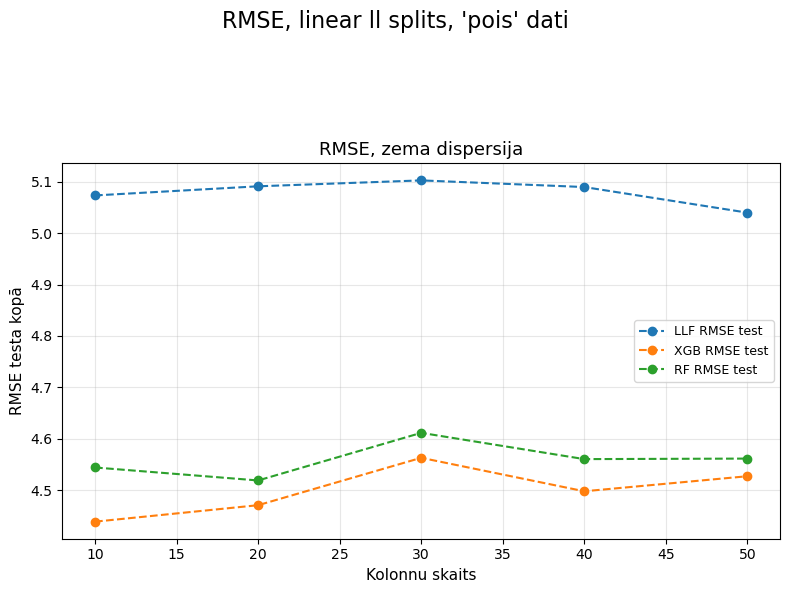

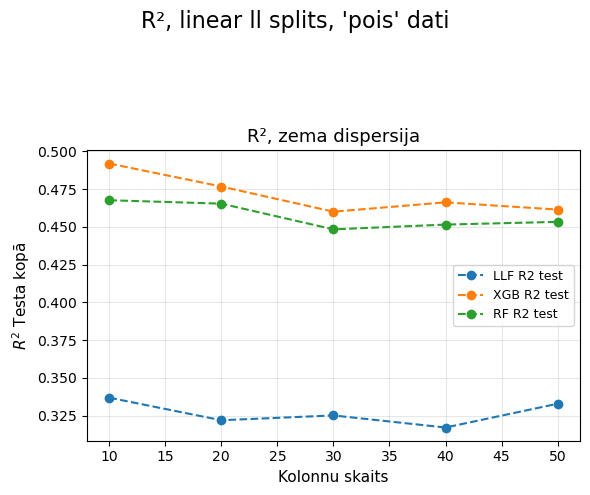

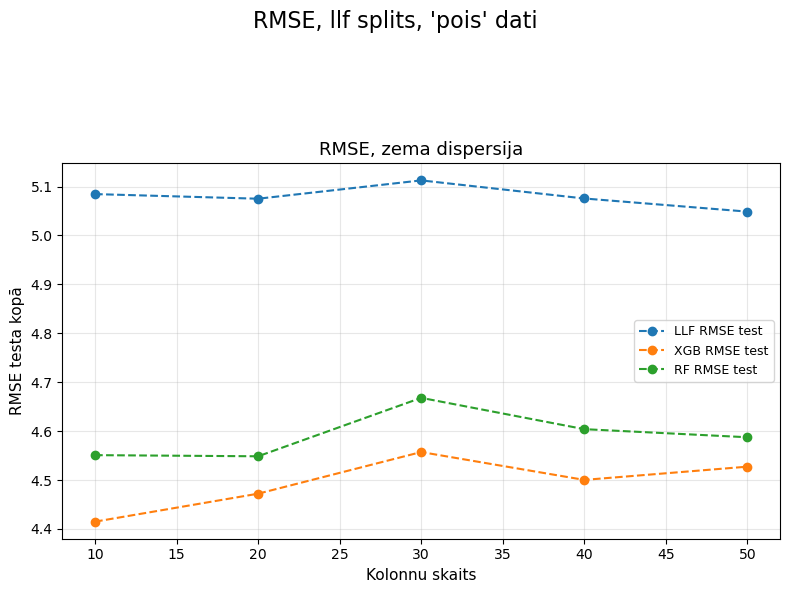

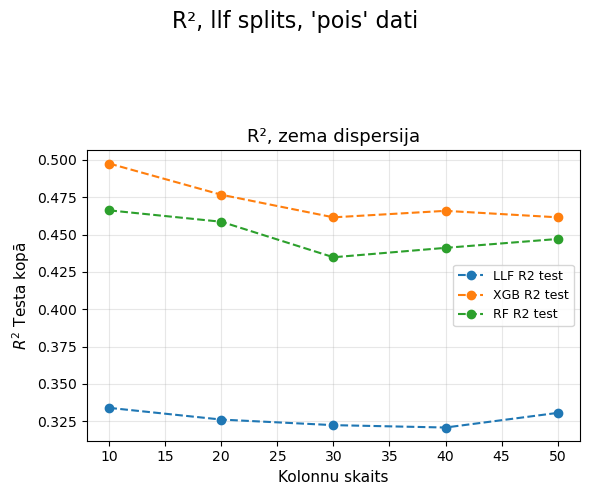

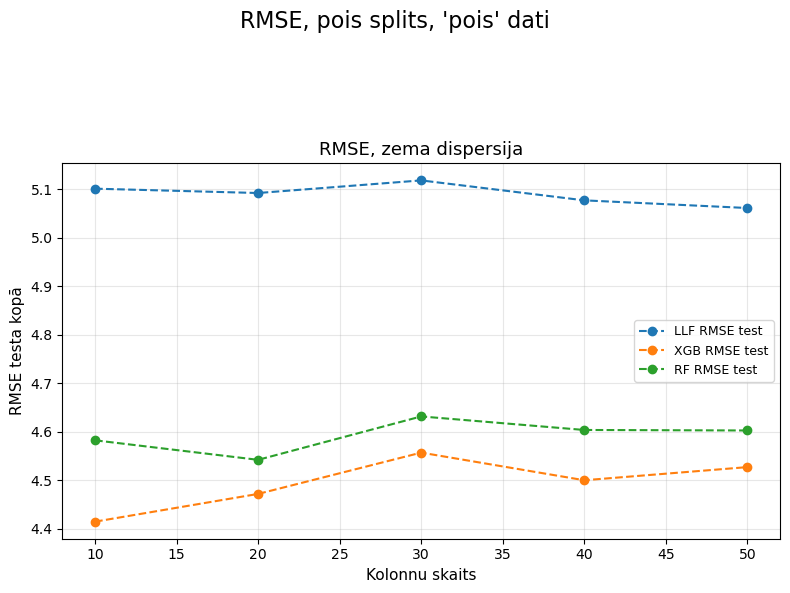

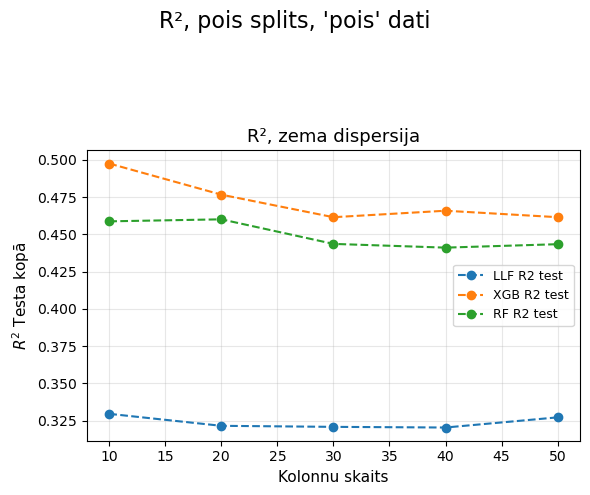

In [190]:
def pretty2(data_filtered, split_type, data_kind):
    dta_rmse = data_filtered[['var_kind', 'nr_cols',
                              'LLF RMSE test',
                              'XGB RMSE test',
                              'RF RMSE test']]
    
    grp_rmse = dta_rmse.groupby(['var_kind', 'nr_cols']).mean().reset_index()
    dta_r2 = data_filtered[['var_kind', 'nr_cols',
                            'LLF R2 test',
                            'XGB R2 test',
                            'RF R2 test']]
    grp_r2 = dta_r2.groupby(['var_kind', 'nr_cols']).mean().reset_index()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    fig.suptitle(f"RMSE, {split_type}, '{data_kind}' dati", fontsize=16)
    fig.subplots_adjust(top=0.85)

    models_rmse = ['LLF RMSE test', 'XGB RMSE test', 'RF RMSE test']
    varieties = ['low var', 'high var']
    titles_rmse = ['RMSE, zema dispersija', 'RMSE, augsta dispersija']

    for i, var_kind in enumerate(varieties):
        ax = axes[i]
        subset = grp_rmse[grp_rmse['var_kind'] == var_kind]
        for model_name in models_rmse:
            ax.plot(
                subset['nr_cols'],
                subset[model_name],
                marker='o',
                linestyle='-' if var_kind == 'low var' else '--',
                label=model_name
            )
        ax.set_xlabel('Kolonnu skaits', fontsize=11)
        if i == 0:
            ax.set_ylabel('RMSE testa kopā', fontsize=11)
        ax.set_title(titles_rmse[i], fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.85])  # leave room for the suptitle
    fname = f'split_type_{split_type}_data_kind_{data_kind}.png'
    plt.savefig(fname)
    plt.show()




    fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    fig2.suptitle(f"R²  {split_type}, data: {data_kind}", fontsize=16)
    fig2.subplots_adjust(top=0.85)

    models_r2 = ['LLF R2 test', 'XGB R2 test', 'RF R2 test']
    titles_r2 = ['R², zema dispersija']

    for i, var_kind in enumerate(varieties):
        ax = axes2[i]
        subset = grp_r2[grp_r2['var_kind'] == var_kind]
        for model_name in models_r2:
            ax.plot(
                subset['nr_cols'],
                subset[model_name],
                marker='o',
                linestyle='-' if var_kind == 'low var' else '--',
                label=model_name
            )
        ax.set_xlabel('Kolonnu skaits', fontsize=11)
        if i == 0:
            ax.set_ylabel(r'$R^2$ Testa kopā', fontsize=11)
        ax.set_title(titles_r2[i], fontsize=13)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.85])
    fname = f'split_type_{split_type}_data_kind_{data_kind}_r2.png'
    plt.savefig(fname)
    plt.show()

for data_kind in results['data_kind'].unique():
    for split_type in results['split_type'].unique():
        split_filtered = results[results['split_type'] == split_type]
        data_filtered = split_filtered[split_filtered['data_kind'] == data_kind]
        if data_kind == 'pois':
            pretty3(data_filtered,split_type,data_kind)
        else:
            pretty2(data_filtered,split_type,data_kind)

In [184]:
results[results['data_kind'] == 'pois']['var_kind'].unique()

array(['high var'], dtype=object)

In [178]:
results['data_kind'].value_counts()

data_kind
regular    166
pois       120
Name: count, dtype: int64

In [132]:
results.groupby(['data_kind','split_type']).count()[['LLF R2 train']]

LLF R2 train
data_kind split_type                    
pois      linear ll splits             9
          llf splits                   9
          pois splits                  9
regular   linear ll splits            80
          llf splits                  86